# Task 4: Create a RL agent for Minirace (level 2)

Deep Q-Learning (DQN) is a reinforcement learning algorithm that combines Q-Learning with a neural network function approximator. Instead of storing a tabular Q-value for every state-action pair, the network predicts Q-values from high-dimensional or continuous states, enabling learning in environments with larger or continuous state spaces. In the level-2 Minirace environment, the state consists of two continuous variables representing track offsets, making DQN a suitable choice because it can generalize across similar states rather than requiring discretization. A single hidden layer was chosen to keep the network lightweight and reduce training time, as deeper architectures would significantly increase computation without substantial gains for this low-dimensional task. This design balances computational efficiency with the capacity to learn a meaningful policy from limited state information.

In [ ]:
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Tuple, List
from minirace import Minirace

### Hyperparameters

In [82]:

SEED = 1
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
# Setting a fixed seed ensures reproducibility of results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use GPU if available for faster training; otherwise fallback to CPU

num_episodes = 8000
# Number of training episodes: large enough to allow convergence of the DQN in level-2 Minirace
# Experimented with 5000, 8000, 10000 episodes; 8000 provided the best performance

gamma = 0.95
# Discount factor: values <1 prioritize shorter-term rewards, suitable for survival-based reward
# 0.95 balances learning from long-term survival while not being too slow to propagate

lr = 5e-3
# Learning rate: faster value to allow stable training without overshooting updates

eps_start = 1.0
eps_end = 0.05
eps_decay_episodes = 4000
# Epsilon-greedy exploration schedule: start fully random (1.0) to encourage exploration,
# decay gradually to 0.05 over 4000 episodes to shift towards exploitation

replay_size = 5000
# Maximum size of the replay buffer: stores recent experience for training,
# balances memory usage and diversity of training samples

batch_size = 64
# Mini-batch size for updates: large enough to smooth gradients but small enough for efficient training

target_update_every = 100
# Frequency to update the target network: stabilizes training by preventing rapid Q-value changes

min_replay_size_before_train = 500
# Minimum number of transitions before starting training:
# ensures the network sees diverse samples initially, avoids bias from early states

test_episodes = 50
# Number of episodes for evaluation of the learned policy: sufficient to estimate mean and standard deviation

render = False
# Optional visualization during training; turned off to speed up computation


A replay buffer, also known as an experience replay buffer or replay memory, is a crucial component in Deep Q-Learning (DQN) and other deep reinforcement learning algorithms. It is a data structure that stores the agent's past experiences, allowing for more stable and efficient learning.

In [83]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        # Use a deque with maxlen to automatically discard oldest transitions
        # when capacity is exceeded. This keeps the buffer size fixed and
        # maintains recent experience for learning.
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, s, a, r, s_next, done):
        # Store a single transition tuple in the buffer.
        # s: current state, a: action taken, r: reward received,
        # s_next: next state, done: whether episode terminated.
        # Using tuples preserves all information for replay sampling.
        self.buffer.append((s, a, r, s_next, done))

    def sample(self, batch_size: int):
        # Randomly sample a minibatch of transitions for training.
        # Random sampling breaks correlation between sequential states,
        # which stabilizes DQN training.
        batch = random.sample(self.buffer, batch_size)
        # Unpack batch into separate arrays for states, actions, rewards, next states, and dones.
        s, a, r, s_next, done = map(np.array, zip(*batch))
        return s, a, r, s_next, done

    def __len__(self):
        # Return current number of stored transitions. Useful for checking
        # if we have enough experience to start training.
        return len(self.buffer)



I expand upon the Q-Learning approach from level 1 to now use Deep Q-Learning (DQN) with a neural network function approximator. In particular, I implement a single hidden layer neural network to predict Q-values from the continuous state inputs of the level-2 Minirace environment. This allows the agent to generalize across similar states rather than requiring discretization. Deep Q-Learning is suitable here because the state space is continuous and low-dimensional, making it feasible to learn effective policies with a simple network architecture. The single hidden layer keeps the model lightweight and reduces training time, while still providing enough capacity to learn meaningful representations from the two-dimensional state input.

In [84]:
# Single Hidden Layer DQN
class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, n_actions=3):
        super().__init__()
        # First fully connected layer maps the input state vector to hidden representation
        # input_dim=2 corresponds to [dx1, dx2] from level 2 Minirace state
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # hidden_dim=32 chosen to balance capacity and speed
        self.relu = nn.ReLU()  # Non-linearity allows the network to approximate non-linear Q-functions
        # Output layer maps hidden representation to Q-values for each possible action
        # n_actions=3 corresponds to {left, straight, right}
        self.fc2 = nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        # Apply first layer and ReLU activation
        x = self.relu(self.fc1(x))
        # Compute Q-values for all actions
        return self.fc2(x)


Without the following functions, I would have to manually write this logic everywhere, making the code messy, harder to read, and error-prone. The functions encapsulate standard RL operations so the training loop can remain clean and focused.

- linear_epsilon: Controls exploration vs. exploitation over time

- choose_action: Implements the epsilon-greedy policy to decide the agent’s actions

- compute_td_loss: Calculates the loss for updating the DQN based on sampled experiences

In [85]:
def linear_epsilon(episode):
    # Linearly decay epsilon from eps_start to eps_end over eps_decay_episodes
    if episode >= eps_decay_episodes:
        return eps_end  # After decay period, keep epsilon at minimum
    frac = episode / eps_decay_episodes  # Fraction of decay completed
    return eps_start + frac * (eps_end - eps_start)  # Linear interpolation

def choose_action(policy_net, state, epsilon):
    # Select an action using epsilon-greedy strategy
    if random.random() < epsilon:
        return random.randint(0, 2)  # Explore: choose random action
    # Exploit: choose action with highest predicted Q-value
    state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dim
    with torch.no_grad():  # Disable gradient computation for inference
        qvals = policy_net(state_t)  # Compute Q-values for all actions
    return int(torch.argmax(qvals).item())  # Return action with highest Q-value

def compute_td_loss(policy_net, target_net, optimizer, batch, gamma):
    # Compute the TD loss for a batch of transitions
    s, a, r, s_next, done = batch

    # Convert numpy arrays to torch tensors
    s_t = torch.tensor(s, dtype=torch.float32, device=device)
    a_t = torch.tensor(a, dtype=torch.int64, device=device).unsqueeze(1)  # Action indices
    r_t = torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1)  # Rewards
    s_next_t = torch.tensor(s_next, dtype=torch.float32, device=device)
    done_t = torch.tensor(done.astype(np.float32), device=device).unsqueeze(1)  # Done flags

    # Compute predicted Q-values for taken actions
    q_values = policy_net(s_t).gather(1, a_t)  # Gather Q(s,a) corresponding to actions a

    # Compute target Q-values using target network (no gradients)
    with torch.no_grad():
        next_q_values = target_net(s_next_t).max(1)[0].unsqueeze(1)  # max_a' Q_target(s',a')
    target = r_t + gamma * next_q_values * (1.0 - done_t)  # TD target: r + γ * max Q_next

    # Compute MSE loss between predicted Q-values and TD targets
    loss = nn.functional.mse_loss(q_values, target)

    # Gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()  # Return scalar loss for logging


### Training the Model

In [86]:
# Training Function
def train_dqn_level2():
    therace = Minirace(level=2)  
    policy_net = DQN().to(device)  # Initialize policy network
    target_net = DQN().to(device)  # Initialize target network
    target_net.load_state_dict(policy_net.state_dict())  # Copy weights from policy to target

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)  # Optimizer for gradient descent
    replay = ReplayBuffer(replay_size)  # Initialize replay buffer to store transitions

    rewards = []  
    running_reward = 0.0  

    for episode in range(1, num_episodes + 1):
        s = np.array(therace.reset(), dtype=np.float32)  # Reset environment at start of episode
        done = False
        total_r = 0.0  # Accumulate reward for this episode
        eps = linear_epsilon(episode)  # Decay epsilon for exploration/exploitation
        steps = 0

        while not done:
            a = choose_action(policy_net, s, eps)  # Choose action with epsilon-greedy policy
            s_next, r, done = therace.step(a)  # Take step in environment
            s_next = np.array(s_next, dtype=np.float32)  # Ensure state is float32
            replay.push(s, a, r, s_next, done)  # Store transition in replay buffer
            s = s_next  # Move to next state
            total_r += r  # Update cumulative reward
            steps += 1

            # Train network once enough transitions are collected
            if len(replay) >= min_replay_size_before_train:
                batch = replay.sample(batch_size)  # Sample mini-batch from replay buffer
                compute_td_loss(policy_net, target_net, optimizer, batch, gamma)  # Update weights

            if render:
                therace.render(text=False, reward=total_r)  # Optional visualization

        rewards.append(total_r)  # Store total episode reward
        
        # Update running reward for smoother performance monitoring
        running_reward = 0.05 * total_r + 0.95 * running_reward

        # Update target network periodically to stabilize Q-value targets
        if episode % target_update_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Logging every 100 episodes
        if episode % 100 == 0:
            avg100 = np.mean(rewards[-100:])  # Average reward over last 100 episodes
            print(f"Ep {episode:5d} | AvgReward(100)={avg100:6.2f} | "
                  f"RunningReward={running_reward:6.2f} | eps={eps:.3f} | replay={len(replay)}")

    # Plot training rewards
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label="Cumulative Rewards per Episode")  
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), label="Average per 100 Episodes")  
    plt.axhline(50, color='r', linestyle='--', label="Average Target Reward (50)")  # Reference line for target
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training – Minirace Level 2")
    plt.legend()
    plt.show()

    return policy_net, rewards,  therace  # Return trained network, rewards,  and environment



### Testing the Model

In [87]:
def test_policy(policy_net, env, n_episodes=50, max_steps=500):
    """
    Evaluate a trained policy network over multiple episodes.

    Parameters:
    - policy_net: trained DQN policy network
    - env: the Minirace environment
    - n_episodes: number of episodes to test
    - max_steps: maximum steps per episode

    Returns:
    - mean: average total reward over episodes
    - std: standard deviation of total reward
    - results: list of total rewards per episode
    """
    results = []  
    for ep in range(n_episodes):
        s = np.array(env.reset(), dtype=np.float32)  # reset environment, get initial state
        total = 0.0  # cumulative reward for this episode
        for t in range(max_steps):
            # convert state to torch tensor for policy network input
            s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():  # no gradients needed during evaluation
                a = int(torch.argmax(policy_net(s_t)).item())  # greedy action selection
            s, r, done = env.step(a)  # take action in environment
            s = np.array(s, dtype=np.float32)  # convert next state to float array
            total += r  # accumulate reward
            if done:  # stop if episode finished
                break
        results.append(total)  # save total reward for this episode
    mean, std = np.mean(results), np.std(results)  # compute mean and std over all episodes
    return mean, std, results  # return evaluation metrics and raw results


### Main Loop for Running Training and Testing

Ep   100 | AvgReward(100)=  2.31 | RunningReward=  2.76 | eps=0.976 | replay=331
Ep   200 | AvgReward(100)=  2.21 | RunningReward=  2.26 | eps=0.953 | replay=652
Ep   300 | AvgReward(100)=  2.61 | RunningReward=  2.23 | eps=0.929 | replay=1013
Ep   400 | AvgReward(100)=  2.44 | RunningReward=  2.81 | eps=0.905 | replay=1357
Ep   500 | AvgReward(100)=  2.40 | RunningReward=  2.50 | eps=0.881 | replay=1697
Ep   600 | AvgReward(100)=  2.41 | RunningReward=  2.70 | eps=0.858 | replay=2038
Ep   700 | AvgReward(100)=  3.53 | RunningReward=  3.63 | eps=0.834 | replay=2491
Ep   800 | AvgReward(100)=  3.32 | RunningReward=  3.51 | eps=0.810 | replay=2923
Ep   900 | AvgReward(100)=  3.38 | RunningReward=  3.73 | eps=0.786 | replay=3361
Ep  1000 | AvgReward(100)=  3.94 | RunningReward=  3.77 | eps=0.762 | replay=3855
Ep  1100 | AvgReward(100)=  3.35 | RunningReward=  3.76 | eps=0.739 | replay=4290
Ep  1200 | AvgReward(100)=  3.61 | RunningReward=  4.12 | eps=0.715 | replay=4751
Ep  1300 | AvgRewa

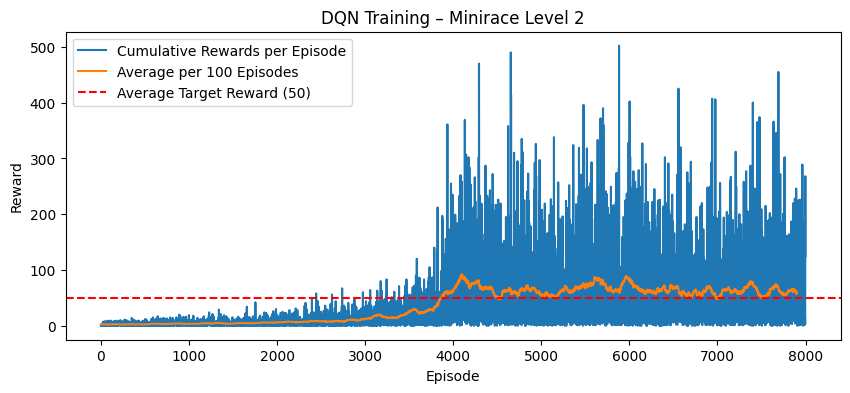


Test results (greedy policy): mean=500.00, std=0.00


In [88]:
if __name__ == "__main__":
    # Train the DQN agent on Level 2 MiniRace
    policy_net, rewards, therace = train_dqn_level2()

    # Evaluate the trained policy
    mean, std, test_rewards = test_policy(policy_net, therace)

    # Print summary of test performance
    print(f"\nTest results (greedy policy): mean={mean:.2f}, std={std:.2f}")